# Syncing spike data with pycontrol

In [1]:
%reload_ext autoreload
%autoreload 2

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr
from trialexp.process.pycontrol import event_filters
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')

In [3]:
figure_output = Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/processed/figures/ephys')

In [4]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

# Manually get the start time for now
# TODO: fix the bug in create_folder
tstart = rec_properties.tstart.iloc[0]
tstart

626.1124

# Data sync

In [5]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
assert rsync is not None

In [9]:
#load the spike extractor
probeB_sorting = si.load_extractor(path/'ProbeB')

In [10]:
# Sync and  all the sorting to ms
# spike time from sorting count from the beginning of the recording
# where the rsync time count from the beginning of the open ephys session
# so we need to shift the spike time to the ephys rsync time unit first

def get_sorting_spiketime(sorting,rsync,tstart, Fs=30000):
    spike_times = []
    max_time = 0
    for id in tqdm(probeB_sorting.get_unit_ids()):
        spk_time = probeB_sorting.get_unit_spike_train(id)
        spk_time = (spk_time/Fs+tstart)*1000 #need to shift by the starting time of recording
        spk_time = rsync.A_to_B(spk_time)

        if len(spk_time)>0:
            max_time = max(max_time, spk_time[-1])
        spike_times.append(spk_time)
    return spike_times

spike_times = get_sorting_spiketime(probeB_sorting, rsync, tstart)

  0%|          | 0/915 [00:00<?, ?it/s]

In [11]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [12]:
# convert spike timing to firing rate
def calculate_spike_rate(spike_times, bins, bin_size):
    spike_rates = np.zeros((len(bins)-1, len(spike_times)))
    for i in tqdm(range(len(spike_times))):
        count, _ = np.histogram(spike_times[i], bins) 
        spike_rates[:,i] = count * (1000/bin_size)
    return spike_rates

bin_size = 50
bins = np.append(xr_session.time.data, xr_session.time.data[-1]+50) # make sure we cover the whole range

spike_rates = calculate_spike_rate(spike_times, bins, bin_size)


  0%|          | 0/915 [00:00<?, ?it/s]

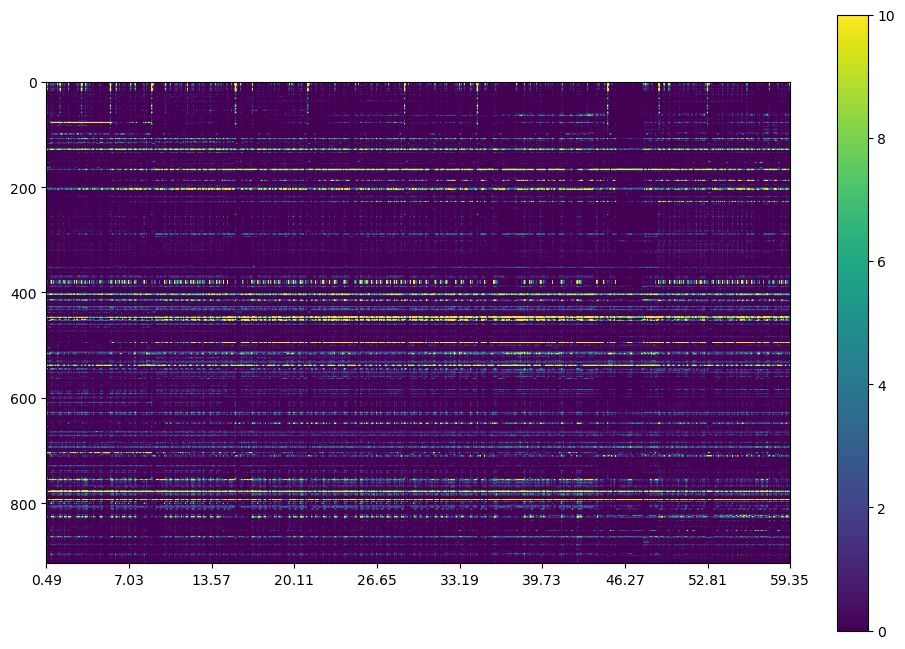

In [13]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.imshow(spike_rates.T, vmax=10)
plt.colorbar()
ax.set_aspect(50)
xticks = np.linspace(0,spike_rates.shape[0],10).astype(int)
ax.set_xticks(xticks);
labels = [f'{x:.2f}' for x in bins[xticks]/1000/60]
ax.set_xticklabels(labels);

In [15]:
cluster_ids = probeB_sorting.get_unit_ids()
xa_spike_rate = xr.DataArray(
    spike_rates, coords={'time':bins[:-1], 
                         'cluster_id':cluster_ids},
    dims=('time','cluster_id'))

xr_session['spike_rate'] = xa_spike_rate

## Align spike data to events

In [16]:
df_pycontrol = pd.read_pickle(path.parents[1]/'processed'/'df_pycontrol.pkl')
rsync_time = df_pycontrol[df_pycontrol.name=='rsync'].time
pyphoto_aligner = Rsync_aligner(pulse_times_A= rsync_time, 
                pulse_times_B= photo_time, plot=False) #align pycontrol time to pyphotometry time


In [17]:
df_event = pd.read_pickle(path.parents[1]/'processed'/'df_events_cond.pkl')
trial_window = df_event.attrs['trial_window']
dataset = xr_session.copy()

In [18]:
trigger = df_event.attrs['triggers'][0]
event_time_coord = dataset.event_time
sampling_rate = dataset.attrs['sampling_rate']/bin_size #the data has already been downsampled
add_event_data(df_event, event_filters.get_first_event_from_name,
               trial_window, pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', trigger, sampling_rate,
               filter_func_kwargs={'evt_name':trigger}, 
               time_tolerance=bin_size, 
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [19]:
add_event_data(df_event, event_filters.get_first_bar_off, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_bar_off', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [20]:
add_event_data(df_event, event_filters.get_first_spout, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_spout', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [21]:
dataset.to_netcdf(path.parents[1]/'processed'/'xr_spikes_probeB.nc', engine='h5netcdf')

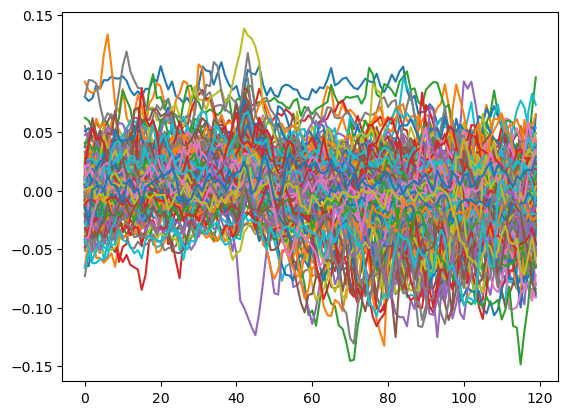

In [22]:
plt.plot(dataset['hold_for_water_analog_1_df_over_f'].data[0,:,:].T);

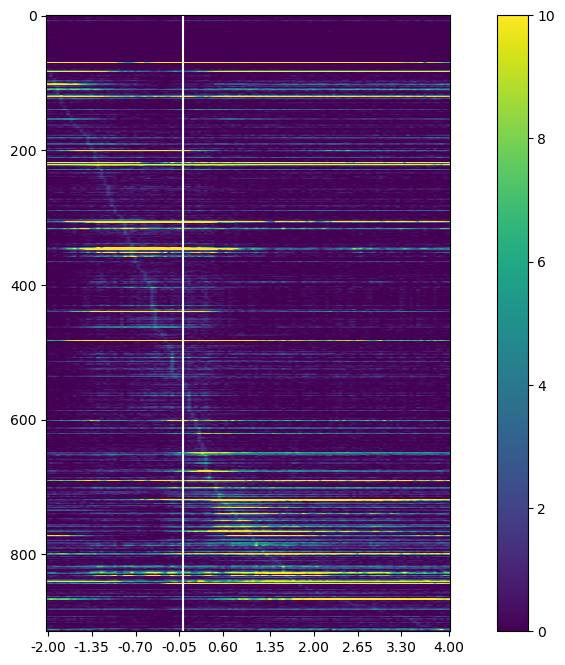

In [28]:
x = np.nanmean(dataset['first_spout_spike_rate'].data,axis=0)

def align_peak(x):
    # Align the data according to peak location
    x = np.nanmean(dataset['first_spout_spike_rate'].data,axis=0)
    maxidx = np.argmax(x,axis=0)
    idx = np.argsort(maxidx)
    
    return x[:,idx], idx

def plot_rate_map(rates, xlabels, vline_x, nxsticks=10):
    # rate is assumed to be a 2D array in the shape (time x channel)
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    plt.imshow(rates.T, vmax=10)
    plt.colorbar()
    ax.set_aspect(0.2)
    
    # figure out the correct tick label
    
    xticks = np.linspace(0,rates.shape[0]-1,nxsticks).astype(int)
    ax.set_xticks(xticks);
    labls = np.array([f'{x:.2f}' for x in xlabels])
    ax.set_xticklabels(labls[xticks]);
    
    # find the cloest match 0 point
    zero_pt = np.argmin(abs(vline_x-xlabels))
    
    ax.axvline(zero_pt,color='w')

xlabels = np.round(dataset.event_time.data/50)*50 #round to the nearest 10ms
xsorted,chan_sort_idx = align_peak(x)
plot_rate_map(xsorted, xlabels/1000, 0)

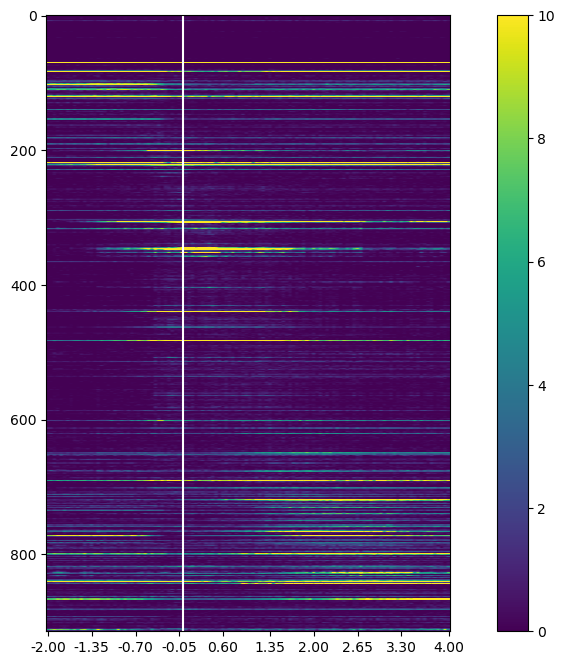

In [29]:
x = np.nanmean(dataset['first_bar_off_spike_rate'].data,axis=0)
xlabels = np.round(dataset.event_time.data/50)*50 #round to the nearest 10ms
plot_rate_map(x[:,chan_sort_idx], xlabels/1000, 0)